## Experiment-0:  COCO

Training params: 
    - Batch size: 16
    - Image type: Full image
    - Background subtraction: False
    - Background subtraction value: 0.0
    - Image-size: 32 x 32
    - Optimizer: Adam
    - Initial LR: 0.001

## Experiment-1:  COCO


Training params:

    - Batch size: 64
    - Image type: Full image
    - Background subtraction: False
    - Background subtraction value: 0.0
    - Kernel size: 7 
    - Image-size: 32 x 32
    - Optimizer: Adam
    - Initial LR: 0.001

In [2]:
import os
os.chdir("/nfs/students/winter-term-2020/project-4/yurtkulus/project-4")

%load_ext autoreload
%autoreload 2

In [3]:
from src.data.coco import COCODataModule
import torch
from src.models.pixelcnn import PixelCNN
from src.models.coco_pixelcnn import COCOPixelCNN
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images
from src.utils.ood_test import plot_roc_auc

import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np

"""
    In order to obtain foreground and background images from COCO dataset, 
    uncomment the lines below.
"""
# from src.data.oodcoco.oodcoco.oodcoco import run
# run()

'\n    In order to obtain foreground and background images from COCO dataset, \n    uncomment the lines below.\n'

In [4]:
print(os.cpu_count())
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
seed_everything(42)

20
cuda:0


42

In [5]:
cocodata_person = COCODataModule(batch_size=64,
                                 foreground_data_dir='./data/COCO/foreground_images/person', 
                                 background_data_dir='./data/COCO/background_images/person', 
                                 convert_grayscale=True, 
                                 normalize=True)
cocodata_person.prepare_data()
cocodata_person.setup()

# cocodata_car = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/car', 
#                               background_data_dir='./data/COCO/background_images/car', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_dog = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/dog', 
#                               background_data_dir='./data/COCO/background_images/dog', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_teddy_bear = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/teddy bear', 
#                               background_data_dir='./data/COCO/background_images/teddy bear/', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_umbrella = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/umbrella', 
#                               background_data_dir='./data/COCO/background_images/umbrella', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_clock = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/clock', 
#                               background_data_dir='./data/COCO/background_images/clock', 
#                               convert_grayscale=True, 
#                               normalize=True)


# experiment_name = 'PixelCNN_COCO_3_Full_Image_bs64_ks7'

experiment_name = 'PixelCNN_COCO_3_Full_Image_bs64_ks7_residual'

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.0000,
   patience=40,
   verbose=True,
)

logger = TensorBoardLogger(
            'lightning_logs', name=experiment_name)

trainer = Trainer(max_epochs=200, gpus=1,logger=logger,  
                  callbacks=[early_stop_callback], auto_lr_find=True, num_sanity_val_steps=0)

EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [8]:
model = COCOPixelCNN()
trainer.fit(model, cocodata_person)

Set SLURM handle signals.

  | Name      | Type       | Params
-----------------------------------------
0 | blocks    | Sequential | 1 M   
1 | MaskAConv | Sequential | 6 K   
2 | MaskBConv | Sequential | 12 M  
3 | out       | Sequential | 33 K  


1

In [6]:
from pathlib import Path

path = Path('models/' + experiment_name)
# path.mkdir(parents=True, exist_ok=True)


# trainer.save_checkpoint(str(path) + '/' + experiment_name + '.ckpt')

In [7]:
model_path = str(path) + '/' + experiment_name + '.ckpt'
eval_model_full_img_residual = COCOPixelCNN().load_from_checkpoint(checkpoint_path=model_path,
                                                          kernel_size=7, 
                                                          padding=3).cuda()
eval_model_full_img_residual.eval()

# eval_model_full_img = COCOPixelCNN().load_from_checkpoint(checkpoint_path=model_path).cuda()
# eval_model_full_img.eval()

# eval_model_bg_subtraction = COCOPixelCNN().load_from_checkpoint(checkpoint_path=model_path, 
#                                                                        background_subtraction=True, 
#                                                                        background_subtraction_value=0.1).cuda()

# eval_model = COCOPixelCNN().load_from_checkpoint(checkpoint_path=model_path, 
#                                                                        background_subtraction=False, 
#                                                                        background_subtraction_value=0.0).cuda()

# eval_model_bg_subtraction.eval()
# eval_model.eval()

COCOPixelCNN(
  (blocks): Sequential(
    (0): MaskedConv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (13): BatchNorm2d(64, e

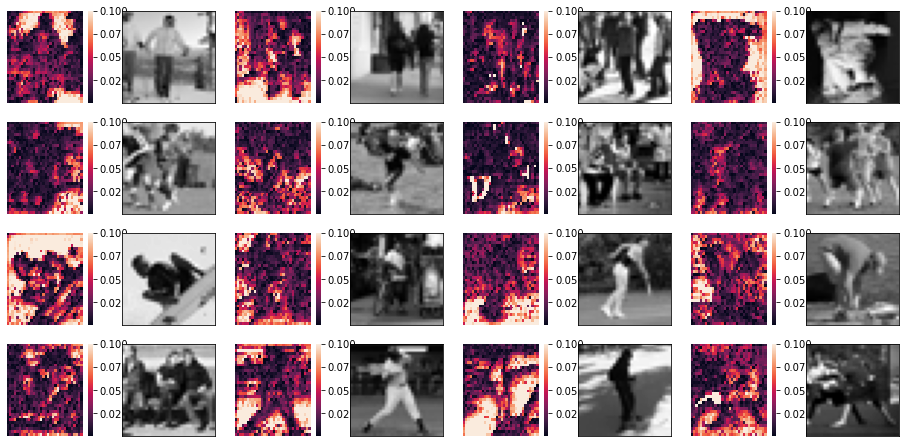

/nfs/students/winter-term-2020/project-4/yurtkulus/project-4/src/utils/pixelcnn.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(out[:, :, i, j]).data


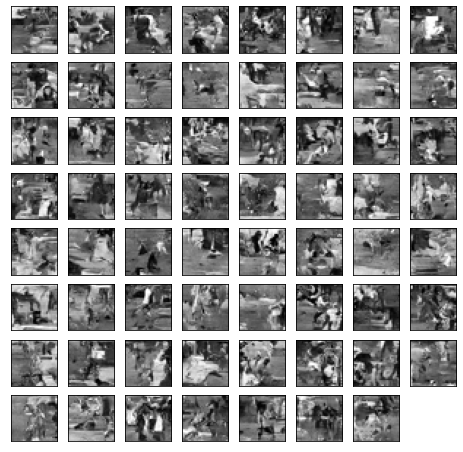

In [8]:
from src.utils.pixelcnn import generate_images, draw_likelihood_plot
draw_likelihood_plot(cocodata_person.test_dataloader(), eval_model_full_img, img_index=0, cmap='rocket')
generate_images(eval_model_full_img, img_dim=(32, 32))

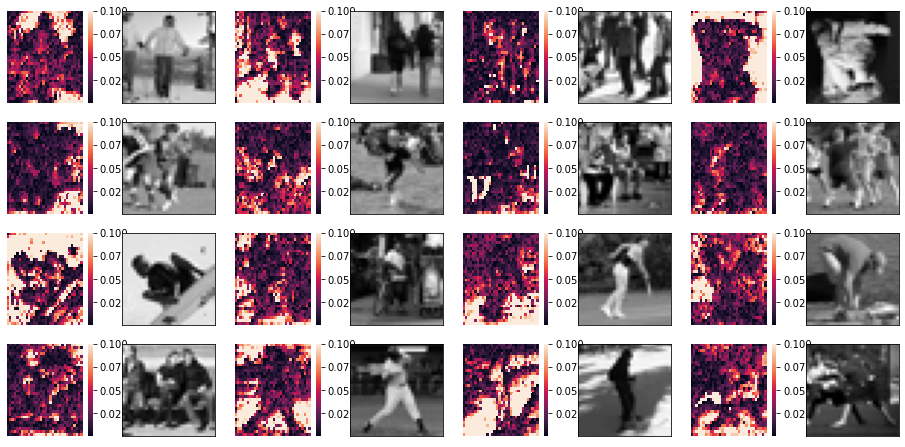

/nfs/students/winter-term-2020/project-4/yurtkulus/project-4/src/utils/pixelcnn.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(out[:, :, i, j]).data


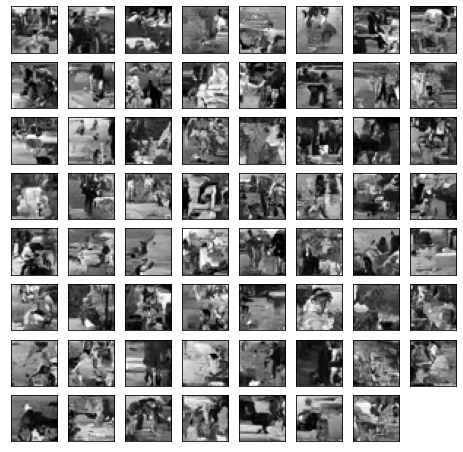

In [8]:
from src.utils.pixelcnn import generate_images, draw_likelihood_plot
draw_likelihood_plot(cocodata_person.test_dataloader(), eval_model_full_img_residual, img_index=0, cmap='rocket')
generate_images(eval_model_full_img_residual, img_dim=(32, 32))